In [215]:
# import:
import random
import itertools
import math
import matplotlib.pyplot as plt
from os import stat
import numpy as np

# indexing:
STARTING = 0
DESTINATION = 1
COLUMN = 0
ROW = 1

In [216]:
## SIMULATION 1:
# adjustable variables

# bounded variables

In [217]:
## SIMULATION 3:
# adjustable variables

# bounded variables

In [250]:
## SIMULATION 2:
# adjustable variables:
n_cols = 11                                     # +2 for the end grid               # number of columns of the street
n_rows = 11                                                                         # number of rows of the street
num_of_pedestrian = 25                                                              # number of pedestrians
sl_coverage = 1                                                                     # street light coverage area (excluding the light)
md_coverage = 1                                                                     # motion detection coverage area (excluding the light)
brightness_lvl_lowest = 1                                                           # lowest brightness level
brightness_lvl_highest = 4                                                          # highest brightness level
nl_opt = [[1],[0],[1]]
actions_delay = 3                                                                   # natural light level (3 = darkest)
episodes = 300000                                                                   # total number of episodes
alpha = 0.1                                                                         # learning rate
gamma = 0.9                                                                         # discount factor
custom_gamma = 0
epsilon_decay = 0.9999
# bounded variables:
positions = [(0, int((n_rows-1)/2)), (int((n_cols-1)), int((n_rows-1)/2)), \
    (int((n_cols-1)/2), int((n_rows-1))), (int((n_cols-1)/2), 0)]                   # number of end points
intersection = (int((n_cols-1)/2), int((n_rows-1)/2))                               # intersection coordinate (tuple, will change to list when there are more than one)
tds = list(range(1, int((num_of_pedestrian + 1)//4)))                               # list of time delay
brightness_lvl = list(range(brightness_lvl_lowest, (brightness_lvl_highest + 1)))   # list of brightness level

In [219]:
## SIMULATION 2: 
class PedestriansMaker():
    
    def __init__(self, n_cols, n_rows, positions, num_of_pedestrian, tds, intersection):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.positions = positions
        self.num_of_pedestrian = num_of_pedestrian
        self.tds = tds
        self.intersection = intersection
        self.list_sd = self.create_starting_destination(self.positions)
        self.pedestrians_sd = self.create_pedestrians_sd(self.num_of_pedestrian, self.list_sd)
        self.pedestrians_s = self.pedestrians_sd[STARTING]
        self.pedestrians_d = self.pedestrians_sd[DESTINATION]
        self.pedestrians_pathway = self.create_pathway(self.pedestrians_s, self.pedestrians_d)
        self.pedestrians_td = self.create_pedestrians_td(self.pedestrians_s, self.tds)
  
    @staticmethod
    def create_starting_destination(positions):
        starting_pt = positions # since list mentioned in the init method, can we put self.positions?
        destination_pt = positions
        list_sd = []
        for starting, destination in itertools.product(starting_pt, destination_pt):
            if starting != destination:
                list_sd.append((starting, destination))
        return list_sd # return a list of tuple [starting destination option]

    @staticmethod
    def create_pedestrians_sd(num_of_pedestrian, list_sd):
        pedestrian_s = []
        pedestrian_d = []
        for idx_pedestrian_starting in range(num_of_pedestrian):
            pedestrian_sd = random.choice(list_sd)
            pedestrian_s.append(pedestrian_sd[STARTING])
            pedestrian_d.append(pedestrian_sd[DESTINATION])
            pedestrians_sd = [pedestrian_s, pedestrian_d]
        return pedestrians_sd # return list of tuple [starting][destination]
    
    @staticmethod
    def create_pathway(pedestrians_s, pedestrians_d):
        pedestrians_pathway = []
        for idx_pedestrian in range(len(pedestrians_s)):
            pedestrian_s = pedestrians_s[idx_pedestrian]
            pedestrian_d = pedestrians_d[idx_pedestrian]
            pathway_len = tuple(np.subtract(pedestrian_d, pedestrian_s))
            pathway_len_col = pathway_len[COLUMN]
            pathway_len_row = pathway_len[ROW]
            pathway = ()
            if pathway_len_col == 0:
                pathway = pathway + (0,)
            else:
                pathway = pathway + (int(pathway_len_col/abs(pathway_len_col)),)
            if pathway_len_row == 0:
                pathway = pathway + (0,)
            else:
                pathway = pathway + (int(pathway_len_row/abs(pathway_len_row)),)
            pedestrians_pathway.append(pathway)
        return pedestrians_pathway # return the direction of a pedestrian

    @staticmethod
    def create_pedestrians_td(pedestrians_s, tds):
        pedestrians_td = []
        for idx_pedestrian in range(len(pedestrians_s)):
            pedestrians_td.append(random.choice(tds))
        return pedestrians_td # return the list of pedestrians' time delay

    @staticmethod
    def pedestrian_loc_update(n_cols, n_rows, list_current_pedestrian, pedestrians_pathway, pedestrians_s, pedestrians_d, pedestrians_td, intersection, time):
        updated_pedestrian_loc = []
        for idx_pedestrian in range(len(pedestrians_pathway)):
            pedestrian_loc = list_current_pedestrian[idx_pedestrian]
            pedestrian_col = pedestrian_loc[COLUMN]
            pedestrian_row = pedestrian_loc[ROW]
            pedestrian_pathway = pedestrians_pathway[idx_pedestrian]
            pedestrian_pathway_col = pedestrian_pathway[COLUMN]
            pedestrian_pathway_row = pedestrian_pathway[ROW]
            pedestrian_s = pedestrians_s[idx_pedestrian]
            pedestrian_s_col = pedestrian_s[COLUMN]
            pedestrian_s_row = pedestrian_s[ROW]
            pedestrian_d = pedestrians_d[idx_pedestrian]
            pedestrian_d_col = pedestrian_d[COLUMN]
            pedestrian_d_row = pedestrian_d[ROW]
            pedestrian_td = pedestrians_td[idx_pedestrian]
            intersection_col = intersection[COLUMN]
            intersection_row = intersection[ROW]
            if pedestrian_loc != pedestrian_d:
                if pedestrian_td <= time:
                    if pedestrian_s_col == pedestrian_d_col or pedestrian_s_row == pedestrian_d_row:
                        update_pedestrian_col = pedestrian_col + pedestrian_pathway_col
                        update_pedestrian_row = pedestrian_row + pedestrian_pathway_row
                        updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                    else:
                        if pedestrian_s_col == int((n_cols-1)/2):
                            if pedestrian_row != intersection_row:
                                update_pedestrian_col = pedestrian_col
                                update_pedestrian_row = pedestrian_row + pedestrian_pathway_row
                                updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))  
                            else:
                                update_pedestrian_col = pedestrian_col + pedestrian_pathway_col
                                update_pedestrian_row = pedestrian_row
                                updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                        else:
                            if pedestrian_col != intersection_col:
                                update_pedestrian_col = pedestrian_col + pedestrian_pathway_col
                                update_pedestrian_row = pedestrian_row
                                updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                            else:
                                update_pedestrian_col = pedestrian_col
                                update_pedestrian_row = pedestrian_row + pedestrian_pathway_row 
                                updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                else:
                    updated_pedestrian_loc.append((pedestrian_col, pedestrian_row))
            else:
                    updated_pedestrian_loc.append((pedestrian_col, pedestrian_row))
        return updated_pedestrian_loc # used to update the current location
        
class StreetLightMaker():

    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.street = self.create_street(self.n_cols, self.n_rows)
        self.all_sl_locs = self.create_sl(self.n_cols, self.n_rows, self.sl_coverage)
        self.sl_locs = self.used_sl(self.all_sl_locs, self.street)
        self.all_sls_cvrg_area = self.create_sl_coverage_area(self.n_cols, self.n_rows, self.sl_coverage, self.sl_locs)
        self.sls_cvrg_area = self.used_sl_coverage_area(self.all_sls_cvrg_area, self.street)
        self.all_mds_cvrg_area = self.create_motion_detection_area(self.n_cols, self.n_rows, self.md_coverage, self.sl_locs)
        self.mds_cvrg_area = self.used_motion_detection_area(self.all_mds_cvrg_area, self.street)

    @staticmethod
    def create_street(n_cols, n_rows):
        street = []
        for column in range(n_cols):
            for row in range(n_rows):
                coordinate = (column, row)
                if coordinate[COLUMN] == int((n_cols-1)/2) or coordinate[ROW] == int((n_rows-1)/2):
                    street.append(coordinate)
        return street 

    @staticmethod
    def create_sl(n_cols, n_rows, sl_coverage):
        n_cols = n_cols - 2
        n_rows = n_rows - 2
        sl_cols = list(range((sl_coverage+1), n_cols, (sl_coverage*2+1)))
        sl_rows = list(range((sl_coverage+1), n_rows, (sl_coverage*2+1)))
        
        if sl_cols == []:
            sl_cols = [0]

        if sl_rows == []:
            sl_rows = [0]
            
        sl_locs = []
        for col, row in itertools.product(sl_cols, sl_rows):
            sl_locs.append((col, row))
        
        return sl_locs # return a list of tuple [street light coordinate]

    @staticmethod
    def used_sl(all_sl_locs, street):
        used_sl_locs = []
        for idx_sl in range(len(all_sl_locs)):
            sl_loc = all_sl_locs[idx_sl]
            test_coor = street.count(sl_loc)
            if test_coor != 0:
                used_sl_locs.append(sl_loc)
        return used_sl_locs

    @staticmethod
    def create_sl_coverage_area(n_cols, n_rows, sl_coverage, list_sl_loc):
        list_sl_cvrg_area = []
        for idx_sl in range(len(list_sl_loc)):
            sl_loc = list_sl_loc[idx_sl]
            sl_col = sl_loc[COLUMN]
            sl_row = sl_loc[ROW]
            coverage_col = list(range((sl_col - sl_coverage), (sl_col + sl_coverage + 1)))
            coverage_row = list(range((sl_row - sl_coverage), (sl_row + sl_coverage + 1)))
            cols = list(range(1, (n_cols-1)))
            rows = list(range(1, (n_rows-1)))
            coverage_col = list(x for x in coverage_col if x in cols)
            coverage_row = list(x for x in coverage_row if x in rows)
            coverage_coor = []
            for col, row in itertools.product(coverage_col, coverage_row):
                coverage_coor.append((col, row))
            list_sl_cvrg_area.append(coverage_coor)
        return list_sl_cvrg_area # return list of list of tuple

    @staticmethod
    def create_motion_detection_area(n_cols, n_rows, md_coverage, list_sl_loc):
        list_md_cvrg_area = []
        for idx_sl in range(len(list_sl_loc)):
            sl_loc = list_sl_loc[idx_sl]
            sl_col = sl_loc[COLUMN]
            sl_row = sl_loc[ROW]
            coverage_col = list(range((sl_col - md_coverage), (sl_col + md_coverage + 1)))
            coverage_row = list(range((sl_row - md_coverage), (sl_row + md_coverage + 1)))
            rows = list(range(1, n_rows - 1))
            cols = list(range(1, n_cols - 1))
            coverage_row = list(x for x in coverage_row if x in rows)
            coverage_col = list(x for x in coverage_col if x in cols)
            coverage_coor = []
            for col, row in itertools.product(coverage_col, coverage_row):
                coverage_coor.append((col, row))
            list_md_cvrg_area.append(coverage_coor)
        return list_md_cvrg_area # return list of list of tuple

    @staticmethod
    def used_sl_coverage_area(all_sls_cvrg_area, street):
        used_sls_cvrg_area = []
        for idx_sl in range(len(all_sls_cvrg_area)):
            sl = all_sls_cvrg_area[idx_sl]
            sl_cvrg_area = []
            for idx_cvrg in range(len(sl)):
                cvrg_coor = sl[idx_cvrg]
                test_coor = street.count(cvrg_coor)
                if test_coor != 0:
                    sl_cvrg_area.append(cvrg_coor)
            used_sls_cvrg_area.append(sl_cvrg_area)
        return used_sls_cvrg_area

    @staticmethod
    def used_motion_detection_area(all_mds_cvrg_area, street):
        used_mds_cvrg_area = []
        for idx_sl in range(len(all_mds_cvrg_area)):
            sl = all_mds_cvrg_area[idx_sl]
            sl_cvrg_area = []
            for idx_cvrg in range(len(sl)):
                cvrg_coor = sl[idx_cvrg]
                test_coor = street.count(cvrg_coor)
                if test_coor != 0:
                    sl_cvrg_area.append(cvrg_coor)
            used_mds_cvrg_area.append(sl_cvrg_area)
        return used_mds_cvrg_area

class Visualization():
    
    def __init__(self, n_cols, n_rows, positions, num_of_pedestrian, tds, intersection, sl_coverage, md_coverage):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.positions = positions
        self.num_of_pedestrian = num_of_pedestrian
        self.tds = tds
        self.intersection = intersection
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.PM_class = PedestriansMaker(self.n_cols, self.n_rows, self.positions, self.num_of_pedestrian, self.tds, self.intersection)
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.grid_pedestrians = self.create_location_grid(self.n_cols, self.n_rows, self.num_of_pedestrian, self.PM_class.pedestrians_s)
        self.grid_sls = self.create_sl_grid(self.n_cols, self.n_rows, self.SLM_class.sl_locs)
        # self.grid_brightness = self.create_brightness_grid(action, self.n_cols, self.n_rows, self.SLM_class.list_sl_cvrg_area)

    @staticmethod
    def create_location_grid(n_cols, n_rows, num_of_pedestrian, pedestrians_s):
        grid_pedestrian = []
        for idx_row in range(n_rows):
            row = []
            for idx_column in range(n_cols):
                row.append(0)
            grid_pedestrian.append(row)
        for idx_pedestrian in range(num_of_pedestrian):
            pedestrian_s = pedestrians_s[idx_pedestrian]
            grid_pedestrian[pedestrian_s[COLUMN]][pedestrian_s[ROW]] += 1
        return grid_pedestrian # return the grid and each pedestrian position on the grid

    @staticmethod
    def create_sl_grid(n_cols, n_rows, list_sl_loc):
        grid_sl = []
        for idx_row in range(n_rows):
            row = []
            for idx_column in range(n_cols):
                row.append(0)
            grid_sl.append(row)
        for idx_sl in range(len(list_sl_loc)):
            sl_loc = list_sl_loc[idx_sl]
            grid_sl[sl_loc[COLUMN]][sl_loc[ROW]] = 1
        return grid_sl # return the grid and each street light position on the grid

    @staticmethod
    def create_brightness_grid(action, n_cols, n_rows, list_sl_cvrg_area):
        grid_sl_brightness = []
        assert len(action) == len(list_sl_cvrg_area)
        for idx_row in range(n_rows):
            row = []
            for idx_column in range(n_cols):
                row.append(0)
            grid_sl_brightness.append(row)
        for idx_action in range(len(action)):
            sl_cvrg = list_sl_cvrg_area[idx_action]
            sl_action = action[idx_action]
            for idx_cvrg in range(len(sl_cvrg)):
                cvrg_coor = sl_cvrg[idx_cvrg]
                cvrg_col = cvrg_coor[COLUMN]
                cvrg_row = cvrg_coor[ROW]
                grid_sl_brightness[cvrg_col][cvrg_row] = sl_action
        return grid_sl_brightness # return grid for brightness

class Environment():

    def __init__(self, n_cols, n_rows, positions, num_of_pedestrian, tds, intersection, sl_coverage, md_coverage, nl_opt):
        self.time = 0
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.positions = positions
        self.num_of_pedestrian = num_of_pedestrian
        self.tds = tds
        self.intersection = intersection
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.nl_opt = nl_opt
        self.PM_class = PedestriansMaker(self.n_cols, self.n_rows, self.positions, self.num_of_pedestrian, self.tds, self.intersection)
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.Vis_class = Visualization(self.n_cols, self.n_rows, self.positions, self.num_of_pedestrian, self.tds, self.intersection, self.sl_coverage, self.md_coverage)
        self.list_current_pedestrian = self.PM_class.pedestrians_s.copy()
        self.nl = self.natural_light(self.nl_opt)

    @staticmethod
    def natural_light(nl_opt):
        period_length = n_cols + max(tds) - 1
        period_1 = period_3 = math.floor(period_length*(0.2))
        period_2 = period_length - period_1 - period_3
        period = [period_1, period_2, period_3]
        nl = []
        for idx_nl in range(len(nl_opt)):
            nl.append(nl_opt[idx_nl] * period[idx_nl])
        flat_nl = [item for items in nl for item in items]
        return flat_nl

    @staticmethod
    def pedestrian_count(list_sl_cvrg_area, list_current_pedestrian):
        sl_pedestrian_count = []
        for idx_sl in range(len(list_sl_cvrg_area)):
            sl_cvrg_area = list_sl_cvrg_area[idx_sl]
            pedestrian_count = 0
            for idx_pedestrian in range(len(list_current_pedestrian)):
                current_pedestrian_loc = list_current_pedestrian[idx_pedestrian]
                test_coor = sl_cvrg_area.count((current_pedestrian_loc[COLUMN], current_pedestrian_loc[ROW]))
                pedestrian_count = pedestrian_count + test_coor
            if pedestrian_count >= 4: # will be generalized
                pedestrian_count = 4
            sl_pedestrian_count.append(pedestrian_count+1)
        return sl_pedestrian_count

    @staticmethod
    def obs(list_sl_cvrg_area, list_current_pedestrian, nl, time):
        list_pedestrian_detected = [nl[time]]
        for idx_sl in range(len(list_sl_cvrg_area)):
            sl_cvrg_area = list_sl_cvrg_area[idx_sl]
            test_coor = 0
            for idx_pedestrian in range(len(list_current_pedestrian)):
                current_pedestrian_loc = list_current_pedestrian[idx_pedestrian]
                pedestrian_count = sl_cvrg_area.count((current_pedestrian_loc[COLUMN], current_pedestrian_loc[ROW]))
                test_coor = test_coor + pedestrian_count
            if test_coor == 0:
                list_pedestrian_detected.append(test_coor)
            else:
                list_pedestrian_detected.append(1)
        return list_pedestrian_detected
    
    @staticmethod
    def reward(actions, sl_pedestrian_count, nl, time):
        reward_sl = []
        for idx_sl in range(len(actions)):
            sl_action = actions[idx_sl]
            pedestrian_count = sl_pedestrian_count[idx_sl]
            sl_reward = - abs(pedestrian_count - (sl_action + nl[time]))
            reward_sl.append(sl_reward) 
        reward = sum(reward_sl)
        return reward

    @staticmethod
    def done(list_current_pedestrian, pedestrians_d):
        status = []
        for idx_pedestrian in range(len(list_current_pedestrian)):
            current_pedestrian_loc = list_current_pedestrian[idx_pedestrian]
            pedestrian_d = pedestrians_d[idx_pedestrian]
            if current_pedestrian_loc == pedestrian_d:
                status.append(True)
            else:
                status.append(False)
        done = all(status)
        return done

    @staticmethod
    def info():
        pass

    def reset(self):
        self.time = 0
        self.PM_class = PedestriansMaker(self.n_cols, self.n_rows, self.positions, self.num_of_pedestrian, self.tds, self.intersection)
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.list_current_pedestrian = self.PM_class.pedestrians_s.copy()
        list_pedestrian_detected = self.obs(self.SLM_class.sls_cvrg_area, self.list_current_pedestrian, self.nl, self.time)
        return list_pedestrian_detected

    def step(self, actions):
        self.time = self.time + 1
        self.list_current_pedestrian = self.PM_class.pedestrian_loc_update(self.n_cols, self.n_rows, self.list_current_pedestrian, self.PM_class.pedestrians_pathway, self.PM_class.pedestrians_s, self.PM_class.pedestrians_d, self.PM_class.pedestrians_td, self.PM_class.intersection, self.time)
        list_pedestrian_detected = self.obs(self.SLM_class.sls_cvrg_area, self.list_current_pedestrian, self.nl, self.time)
        done = self.done(self.list_current_pedestrian, self.PM_class.pedestrians_d)
        reward = self.reward(actions, self.pedestrian_count(self.SLM_class.sls_cvrg_area, self.list_current_pedestrian), self.nl, self.time)
        info = {
            'time' : self.time,
            'actions' : actions,
            'sl pedestrian count' : self.pedestrian_count(self.SLM_class.sls_cvrg_area, self.list_current_pedestrian),
        }
        return list_pedestrian_detected, done, reward, info

    def render(self):
        grid = []
        for rows in self.Vis_class.grid_pedestrians:
            grid.append(rows)
        return grid

In [234]:
## SIMULATION 2: Agents

# non delay action | random
class Agent_ndR():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            actions.append(np.random.choice(brightness_lvl))
        return actions

# non delay action | always 1
class Agent_nd1():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            actions.append(1)
        return actions

# non delay action | always 2
class Agent_nd2():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            actions.append(2)
        return actions

# non delay action | always 3
class Agent_nd3():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            actions.append(3)
        return actions

# non delay action | always 4
class Agent_nd4():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            actions.append(4)
        return actions

# non delay action | 0-1 and 1-2
class Agent_nd12():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(2)
        return actions

# non delay action | 0-1 and 1-3
class Agent_nd13():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(3)
        return actions

# non delay action | 0-1 and 1-4
class Agent_nd14():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(4)
        return actions

# non delay action | qlearning
class Agent_ndQ():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(self.brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        state_idx = self.state_idx(obs)
        actions_idx = np.random.choice(np.flatnonzero(qtable[state_idx, :] == qtable[state_idx, :].max()))
        actions = self.idx_action(actions_idx, list_sl_loc, brightness_lvl)
        return actions

# non delay action | qlearning epsilon-greedy    
class Agent_ndQe():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(self.brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        actions = []
        if rnd < epsilon:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(np.random.choice(brightness_lvl))
        else:
            state_idx = self.state_idx(obs)
            actions_idx = np.random.choice(np.flatnonzero(qtable[state_idx, :] == qtable[state_idx, :].max()))
            actions = self.idx_action(actions_idx, list_sl_loc, brightness_lvl)
        return actions

# delay action | random
class Agent_dR():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(np.random.choice(brightness_lvl))
        else:
            actions = old_actions
        return actions

# delay action | always 1
class Agent_d1():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(1)
        else:
            actions = old_actions
        return actions

# delay action | always 2
class Agent_d2():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(2)
        else:
            actions = old_actions
        return actions

# delay action | always 3
class Agent_d3():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(3)
        else:
            actions = old_actions
        return actions

# delay action | always 4
class Agent_d4():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(4)
        else:
            actions = old_actions
        return actions

# delay action | 0-1 and 1-2
class Agent_d12():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                if obs[idx_sl] == 0:
                    actions.append(1)
                else:
                    actions.append(2)
        else:
            actions = old_actions
        return actions

# delay action | 0-1 and 1-3
class Agent_d13():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                if obs[idx_sl] == 0:
                    actions.append(1)
                else:
                    actions.append(3)
        else:
            actions = old_actions
        return actions

# delay action | 0-1 and 1-4
class Agent_d14():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                if obs[idx_sl] == 0:
                    actions.append(1)
                else:
                    actions.append(4)
        else:
            actions = old_actions
        return actions

# delay action | qlearning
class Agent_dQ():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(self.brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(actions, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            state_idx = self.state_idx(obs)
            action_idx = np.random.choice(np.flatnonzero(qtable[state_idx, :] == qtable[state_idx, :].max()))
            actions = self.idx_action(action_idx, list_sl_loc, brightness_lvl)
        else:
            actions = old_actions
        return actions

# delay action | qlearning epsilon-greedy 
class Agent_dQe():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(actions, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            if rnd < epsilon:
                for idx_sl in range(len(list_sl_loc)):
                    actions.append(np.random.choice(brightness_lvl))
            else:
                state_idx = self.state_idx(obs)
                action_idx = np.random.choice(np.flatnonzero(qtable[state_idx, :] == qtable[state_idx, :].max()))
                actions = self.idx_action(action_idx, list_sl_loc, brightness_lvl)
        else:
            actions = old_actions
        return actions

In [235]:
sim2_pm = PedestriansMaker(n_cols, n_rows, positions, num_of_pedestrian, tds, intersection)
sim2_slm = StreetLightMaker(n_rows, n_cols, sl_coverage, md_coverage)
sim2_env = Environment(n_cols, n_rows, positions, num_of_pedestrian, tds, intersection, sl_coverage, md_coverage, nl_opt)

sim2_agent_ndR = Agent_ndR(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_nd1 = Agent_nd1(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_nd2 = Agent_nd2(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_nd3 = Agent_nd3(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_nd4 = Agent_nd4(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_nd12 = Agent_nd12(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_nd13 = Agent_nd13(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_nd14 = Agent_nd14(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_ndQ = Agent_ndQ(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_ndQe = Agent_ndQe(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)

sim2_agent_dR = Agent_dR(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_d1 = Agent_d1(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_d2 = Agent_d2(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_d3 = Agent_d3(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_d4 = Agent_d4(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_d12 = Agent_d12(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_d13 = Agent_d13(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_d14 = Agent_d14(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_dQ = Agent_dQ(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim2_agent_dQe = Agent_dQe(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)

final test - non delay action | random


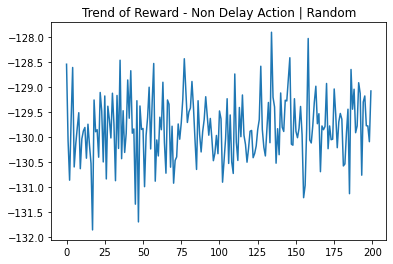

In [222]:
random.seed(21)
print('final test - non delay action | random')

qtable = sim2_agent_ndR.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_ndR.action(qtable, obs, sim2_agent_ndR.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_ndR.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_ndR = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_ndR.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_ndR))), rewards_sim2_mean_ndR)
plt.title("Trend of Reward - Non Delay Action | Random")
plt.show()

final test - non delay action | always 1


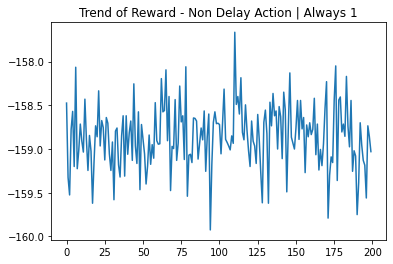

In [223]:
random.seed(21)
print('final test - non delay action | always 1')

qtable = sim2_agent_nd1.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_nd1.action(qtable, obs, sim2_agent_nd1.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_nd1.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_nd1 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_nd1.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_nd1))), rewards_sim2_mean_nd1)
plt.title("Trend of Reward - Non Delay Action | Always 1")
plt.show()

final test - non delay action | always 2


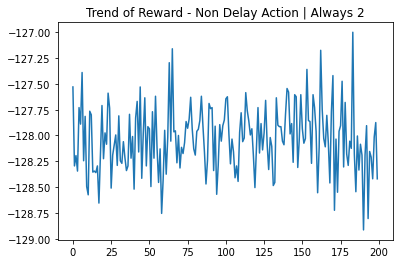

In [224]:
random.seed(21)
print('final test - non delay action | always 2')

qtable = sim2_agent_nd2.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_nd2.action(qtable, obs, sim2_agent_nd2.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_nd2.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_nd2 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_nd2.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_nd2))), rewards_sim2_mean_nd2)
plt.title("Trend of Reward - Non Delay Action | Always 2")
plt.show()

final test - non delay action | always 3


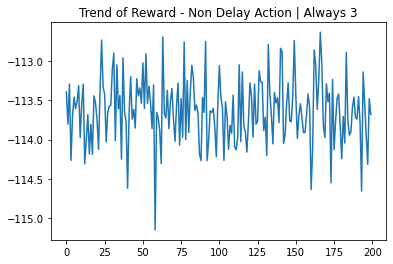

In [225]:
random.seed(21)
print('final test - non delay action | always 3')

qtable = sim2_agent_nd3.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_nd3.action(qtable, obs, sim2_agent_nd3.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_nd3.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_nd3 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_nd3.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_nd3))), rewards_sim2_mean_nd3)
plt.title("Trend of Reward - Non Delay Action | Always 3")
plt.show()

final test - non delay action | always 4


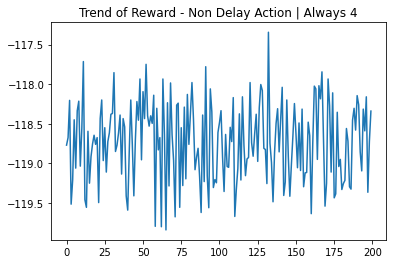

In [226]:
random.seed(21)
print('final test - non delay action | always 4')

qtable = sim2_agent_nd4.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_nd4.action(qtable, obs, sim2_agent_nd4.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_nd4.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_nd4 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_nd4.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_nd4))), rewards_sim2_mean_nd4)
plt.title("Trend of Reward - Non Delay Action | Always 4")
plt.show()

final test - non delay action | 0-1 and 1-2


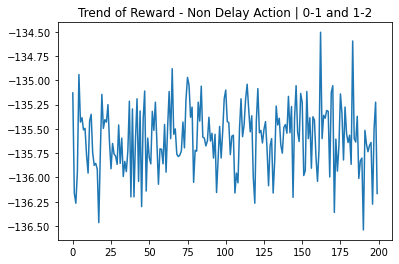

In [227]:
random.seed(21)
print('final test - non delay action | 0-1 and 1-2')

qtable = sim2_agent_nd12.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_nd12.action(qtable, obs, sim2_agent_nd12.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_nd12.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_nd12 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_nd12.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_nd12))), rewards_sim2_mean_nd12)
plt.title("Trend of Reward - Non Delay Action | 0-1 and 1-2")
plt.show()

final test - non delay action | 0-1 and 1-3


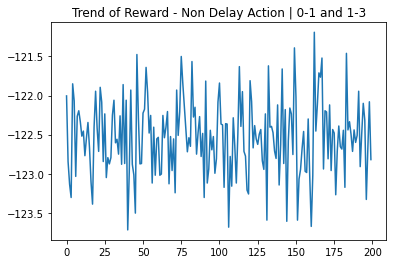

In [228]:
random.seed(21)
print('final test - non delay action | 0-1 and 1-3')

qtable = sim2_agent_nd13.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_nd13.action(qtable, obs, sim2_agent_nd13.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_nd13.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_nd13 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_nd13.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_nd13))), rewards_sim2_mean_nd13)
plt.title("Trend of Reward - Non Delay Action | 0-1 and 1-3")
plt.show()

final test - non delay action | 0-1 and 1-4


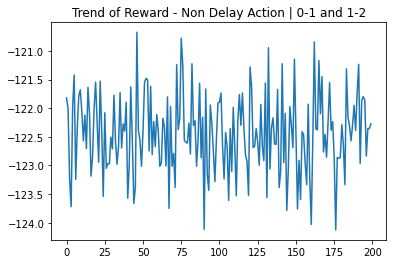

In [236]:
random.seed(21)
print('final test - non delay action | 0-1 and 1-4')

qtable = sim2_agent_nd14.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_nd14.action(qtable, obs, sim2_agent_nd14.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_nd14.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_nd14 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_nd14.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_nd14))), rewards_sim2_mean_nd14)
plt.title("Trend of Reward - Non Delay Action | 0-1 and 1-2")
plt.show()

final test - non delay action | qlearning


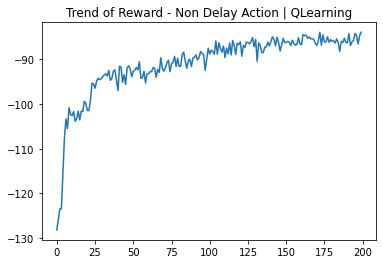

In [237]:
random.seed(21)
print('final test - non delay action | qlearning')

qtable = sim2_agent_ndQ.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_ndQ.action(qtable, obs, sim2_agent_ndQ.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_ndQ.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_ndQ = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_ndQ.append(mean)

epsilons_sim2_ndQ = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(epsilons[idx : idx + 200])
    epsilons_sim2_ndQ.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_ndQ))), rewards_sim2_mean_ndQ)
plt.title("Trend of Reward - Non Delay Action | QLearning")
plt.show()

final test - non delay action | qlearning epsilon-greedy


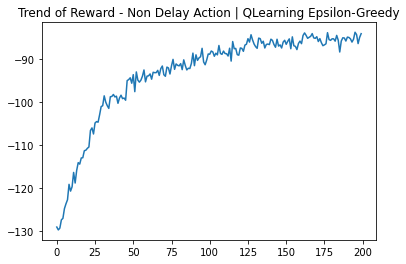

In [238]:
random.seed(21)
print('final test - non delay action | qlearning epsilon-greedy')

qtable = sim2_agent_ndQe.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_ndQe.action(qtable, obs, sim2_agent_ndQe.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_ndQe.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_ndQe = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_ndQe.append(mean)

epsilons_sim2_ndQe = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(epsilons[idx : idx + 200])
    epsilons_sim2_ndQe.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_ndQe))), rewards_sim2_mean_ndQe)
plt.title("Trend of Reward - Non Delay Action | QLearning Epsilon-Greedy")
plt.show()

final test - delay action | random


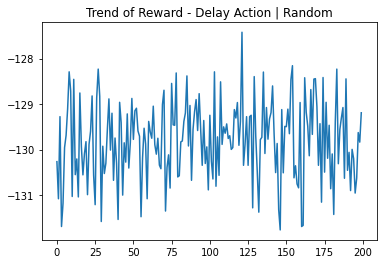

In [239]:
random.seed(21)
print('final test - delay action | random')

qtable = sim2_agent_dR.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    actions = [1 for _ in range(len(sim2_agent_dR.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_dR.action(actions, sim2_env.time, actions_delay, qtable, obs, sim2_agent_dR.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_dR.learn(qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_dR = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_dR.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_dR))), rewards_sim2_mean_dR)
plt.title("Trend of Reward - Delay Action | Random")
plt.show()

final test - delay action | always 1


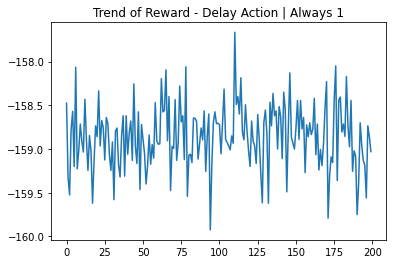

In [240]:
random.seed(21)
print('final test - delay action | always 1')

qtable = sim2_agent_d1.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    actions = [1 for _ in range(len(sim2_agent_d1.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_d1.action(actions, sim2_env.time, actions_delay, qtable, obs, sim2_agent_d1.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_d1.learn(qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_d1 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_d1.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_d1))), rewards_sim2_mean_d1)
plt.title("Trend of Reward - Delay Action | Always 1")
plt.show()

final test - delay action | always 2


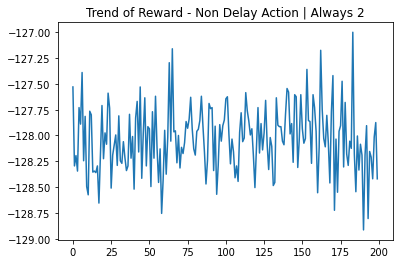

In [241]:
random.seed(21)
print('final test - delay action | always 2')

qtable = sim2_agent_d2.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    actions = [1 for _ in range(len(sim2_agent_d2.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_d2.action(actions, sim2_env.time, actions_delay, qtable, obs, sim2_agent_d2.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_d2.learn(qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_d2 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_d2.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_d2))), rewards_sim2_mean_d2)
plt.title("Trend of Reward - Non Delay Action | Always 2")
plt.show()

final test - delay action | always 3


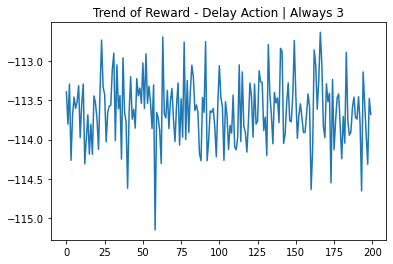

In [242]:
random.seed(21)
print('final test - delay action | always 3')

qtable = sim2_agent_d3.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    actions = [1 for _ in range(len(sim2_agent_d3.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_d3.action(actions, sim2_env.time, actions_delay, qtable, obs, sim2_agent_d3.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_d3.learn(qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_d3 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_d3.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_d3))), rewards_sim2_mean_d3)
plt.title("Trend of Reward - Delay Action | Always 3")
plt.show()

final test - ndelay action | always 4


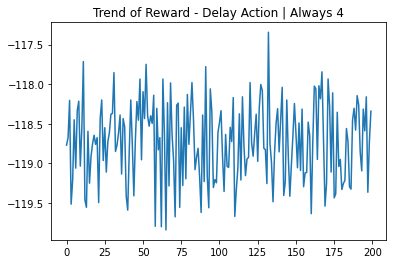

In [243]:
random.seed(21)
print('final test - ndelay action | always 4')

qtable = sim2_agent_d4.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    actions = [1 for _ in range(len(sim2_agent_d4.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_d4.action(actions, sim2_env.time, actions_delay, qtable, obs, sim2_agent_d4.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_d4.learn(qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_d4 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_d4.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_d4))), rewards_sim2_mean_d4)
plt.title("Trend of Reward - Delay Action | Always 4")
plt.show()

final test - delay action | 0-1 and 1-2


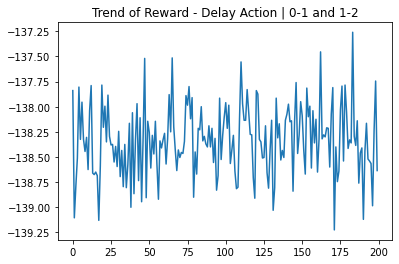

In [244]:
random.seed(21)
print('final test - delay action | 0-1 and 1-2')

qtable = sim2_agent_d12.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    actions = [1 for _ in range(len(sim2_agent_d12.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_d12.action(actions, sim2_env.time, actions_delay, qtable, obs, sim2_agent_d12.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_d12.learn(qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_d12 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_d12.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_d12))), rewards_sim2_mean_d12)
plt.title("Trend of Reward - Delay Action | 0-1 and 1-2")
plt.show()

final test - delay action | 0-1 and 1-3


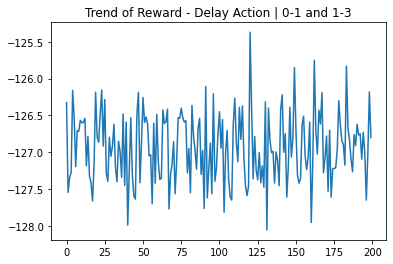

In [245]:
random.seed(21)
print('final test - delay action | 0-1 and 1-3')

qtable = sim2_agent_d13.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    actions = [1 for _ in range(len(sim2_agent_d13.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_d13.action(actions, sim2_env.time, actions_delay, qtable, obs, sim2_agent_d13.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_d13.learn(qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_d13 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_d13.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_d13))), rewards_sim2_mean_d13)
plt.title("Trend of Reward - Delay Action | 0-1 and 1-3")
plt.show()

final test - delay action | 0-1 and 1-4


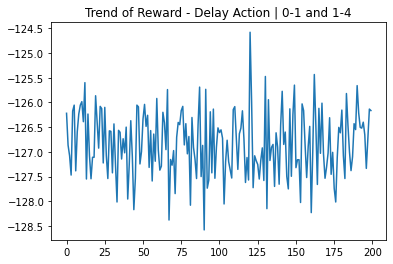

In [246]:
random.seed(21)
print('final test - delay action | 0-1 and 1-4')

qtable = sim2_agent_d14.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    actions = [1 for _ in range(len(sim2_agent_d14.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_d14.action(actions, sim2_env.time, actions_delay, qtable, obs, sim2_agent_d14.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_d14.learn(qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_d14 = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_d14.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_d14))), rewards_sim2_mean_d14)
plt.title("Trend of Reward - Delay Action | 0-1 and 1-4")
plt.show()

final test - delay action | qlearning


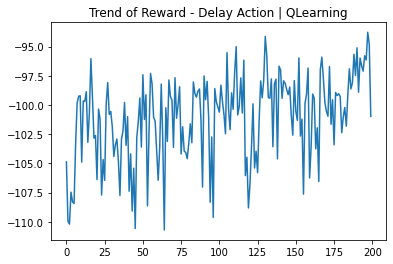

In [251]:
random.seed(21)
print('final test - delay action | qlearning')

qtable = sim2_agent_dQ.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    actions = [1 for _ in range(len(sim2_agent_dQ.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_dQ.action(actions, sim2_env.time, actions_delay, qtable, obs, sim2_agent_dQ.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_dQ.learn(qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_dQ = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_dQ.append(mean)

epsilons_sim2_dQ = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(epsilons[idx : idx + 200])
    epsilons_sim2_dQ.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_dQ))), rewards_sim2_mean_dQ)
plt.title("Trend of Reward - Delay Action | QLearning")
plt.show()

final test - delay action | qlearning epsilon greedy


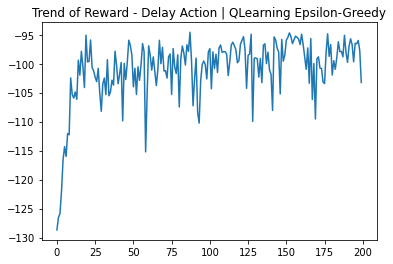

In [252]:
random.seed(21)
print('final test - delay action | qlearning epsilon greedy')

qtable = sim2_agent_dQe.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = sim2_env.reset()
    actions = [1 for _ in range(len(sim2_agent_dQe.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = sim2_agent_dQe.action(actions, sim2_env.time, actions_delay, qtable, obs, sim2_agent_dQe.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = sim2_env.step(actions)
        total_reward += reward
        qtable = sim2_agent_dQe.learn(qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_sim2_mean_dQe = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_sim2_mean_dQe.append(mean)

epsilons_sim2_dQe = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(epsilons[idx : idx + 200])
    epsilons_sim2_dQe.append(mean)

plt.plot(list(range(len(rewards_sim2_mean_dQe))), rewards_sim2_mean_dQe)
plt.title("Trend of Reward - Delay Action | QLearning Epsilon-Greedy")
plt.show()

/var/folders/qn/9bbd28_j67g33m6x99411d1w0000gn/T/ipykernel_12861/4020974913.py:80: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_1.show()
/var/folders/qn/9bbd28_j67g33m6x99411d1w0000gn/T/ipykernel_12861/4020974913.py:81: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_2.show()
/var/folders/qn/9bbd28_j67g33m6x99411d1w0000gn/T/ipykernel_12861/4020974913.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_3.show()


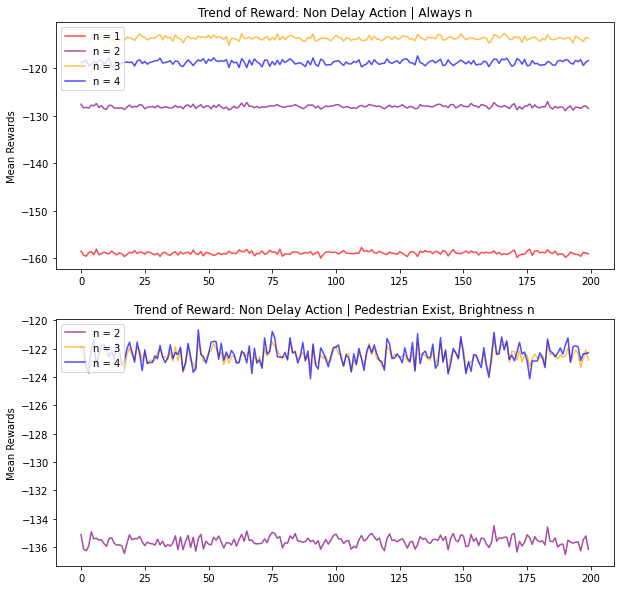

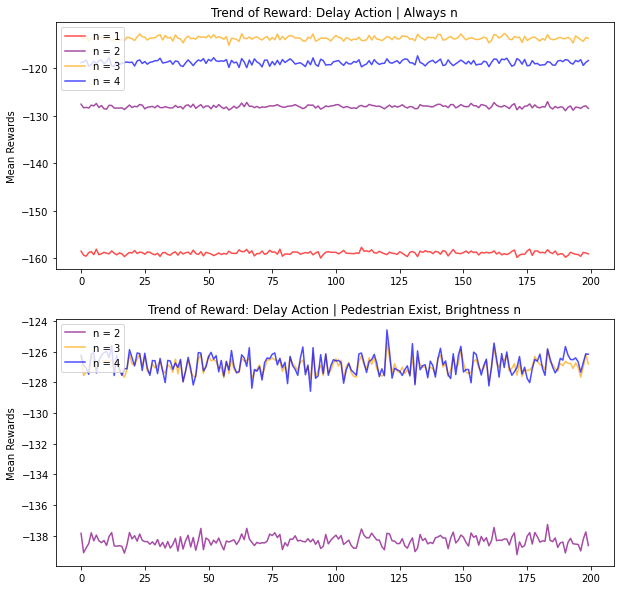

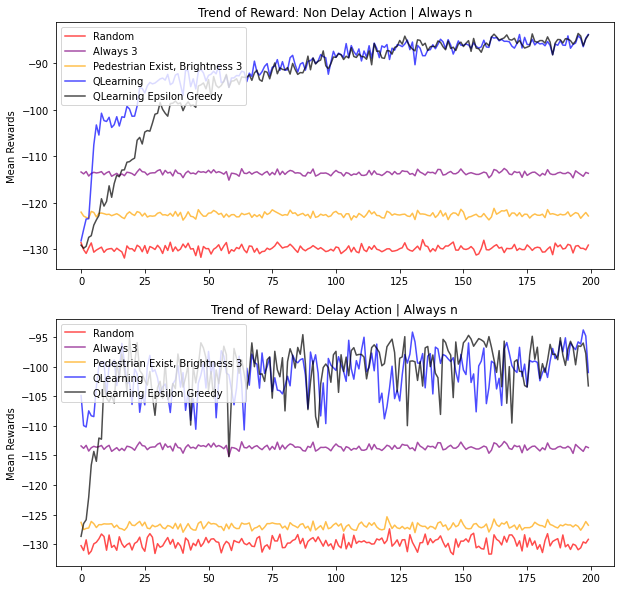

In [253]:
from tkinter import LEFT

ndR = rewards_sim2_mean_ndR
nd1 = rewards_sim2_mean_nd1
nd2 = rewards_sim2_mean_nd2
nd3 = rewards_sim2_mean_nd3
nd4 = rewards_sim2_mean_nd4
nd12 = rewards_sim2_mean_nd12
nd13 = rewards_sim2_mean_nd13
nd14 = rewards_sim2_mean_nd14
ndQ = rewards_sim2_mean_ndQ
ndQe = rewards_sim2_mean_ndQe

dR = rewards_sim2_mean_dR
d1 = rewards_sim2_mean_d1
d2 = rewards_sim2_mean_d2
d3 = rewards_sim2_mean_d3
d4 = rewards_sim2_mean_d4
d12 = rewards_sim2_mean_d12
d13 = rewards_sim2_mean_d13
d14 = rewards_sim2_mean_d14
dQ = rewards_sim2_mean_dQ
dQe = rewards_sim2_mean_dQe

fig_1, ax_1 = plt.subplots(nrows = 2, ncols=1, figsize=(10, 10))

ax_1[0].plot(list(range(len(nd1))), nd1, color = "red", alpha = 0.7)
ax_1[0].plot(list(range(len(nd2))), nd2, color = "purple", alpha = 0.7)
ax_1[0].plot(list(range(len(nd3))), nd3, color = "orange", alpha = 0.7)
ax_1[0].plot(list(range(len(nd4))), nd4, color = "blue", alpha = 0.7)
ax_1[0].set_title("Trend of Reward: Non Delay Action | Always n")
ax_1[0].set_ylabel("Mean Rewards")
ax_1[0].legend(loc='upper left', labels=['n = 1', 'n = 2', 'n = 3', 'n = 4'])

ax_1[1].plot(list(range(len(nd12))), nd12, color = "purple", alpha = 0.7)
ax_1[1].plot(list(range(len(nd13))), nd13, color = "orange", alpha = 0.7)
ax_1[1].plot(list(range(len(nd14))), nd14, color = "blue", alpha = 0.7)
ax_1[1].set_title("Trend of Reward: Non Delay Action | Pedestrian Exist, Brightness n")
ax_1[1].set_ylabel("Mean Rewards")
ax_1[1].legend(loc='upper left', labels=['n = 2', 'n = 3', 'n = 4'])

fig_2, ax_2 = plt.subplots(nrows = 2, ncols=1, figsize=(10, 10))

ax_2[0].plot(list(range(len(d1))), d1, color = "red", alpha = 0.7)
ax_2[0].plot(list(range(len(d2))), d2, color = "purple", alpha = 0.7)
ax_2[0].plot(list(range(len(d3))), d3, color = "orange", alpha = 0.7)
ax_2[0].plot(list(range(len(d4))), d4, color = "blue", alpha = 0.7)
ax_2[0].set_title("Trend of Reward: Delay Action | Always n")
ax_2[0].set_ylabel("Mean Rewards")
ax_2[0].legend(loc='upper left', labels=['n = 1', 'n = 2', 'n = 3', 'n = 4'])

ax_2[1].plot(list(range(len(d12))), d12, color = "purple", alpha = 0.7)
ax_2[1].plot(list(range(len(d13))), d13, color = "orange", alpha = 0.7)
ax_2[1].plot(list(range(len(d14))), d14, color = "blue", alpha = 0.7)
ax_2[1].set_title("Trend of Reward: Delay Action | Pedestrian Exist, Brightness n")
ax_2[1].set_ylabel("Mean Rewards")
ax_2[1].legend(loc='upper left', labels=['n = 2', 'n = 3', 'n = 4'])


fig_3, ax_3 = plt.subplots(nrows = 2, ncols=1, figsize=(10, 10))

ax_3[0].plot(list(range(len(ndR))), ndR, color = "red", alpha = 0.7)
ax_3[0].plot(list(range(len(nd3))), nd3, color = "purple", alpha = 0.7)
ax_3[0].plot(list(range(len(nd13))), nd13, color = "orange", alpha = 0.7)
ax_3[0].plot(list(range(len(ndQ))), ndQ, color = "blue", alpha = 0.7)
ax_3[0].plot(list(range(len(ndQe))), ndQe, color = "black", alpha = 0.7)
ax_3[0].set_title("Trend of Reward: Non Delay Action | Always n")
ax_3[0].set_ylabel("Mean Rewards")
ax_3[0].legend(loc='upper left', labels=['Random', 'Always 3', 'Pedestrian Exist, Brightness 3', 'QLearning', 'QLearning Epsilon Greedy'])

ax_3[1].plot(list(range(len(dR))), dR, color = "red", alpha = 0.7)
ax_3[1].plot(list(range(len(d3))), d3, color = "purple", alpha = 0.7)
ax_3[1].plot(list(range(len(d13))), d13, color = "orange", alpha = 0.7)
ax_3[1].plot(list(range(len(dQ))), dQ, color = "blue", alpha = 0.7)
ax_3[1].plot(list(range(len(dQe))), dQe, color = "black", alpha = 0.7)
ax_3[1].set_title("Trend of Reward: Delay Action | Always n")
ax_3[1].set_ylabel("Mean Rewards")
ax_3[1].legend(loc='upper left', labels=['Random', 'Always 3', 'Pedestrian Exist, Brightness 3', 'QLearning', 'QLearning Epsilon Greedy'])

fig_1.show()
fig_2.show()
fig_3.show()

In [ ]:
# epsilons_av = epsilons_av
# epsilons_bv = epsilons_bv

# fig_2, ax_2 = plt.subplots(nrows = 1, ncols=1, figsize=(20, 10))

# ax_2[0].plot(list(range(len(epsilons_av))), epsilons_av, color = "red", alpha = 0.7)
# ax_2[0].plot(list(range(len(epsilons_bv))), epsilons_bv, color = "purple", alpha = 0.7)
# ax_2[0].set_title("Trend of Epsilons")
# ax_2[0].set_ylabel("Epsilon Value")

# fig_2.show()